## Problem 2A (exercise 8)

This notebook demonstrates how to create and run problem 2a (exercise 8) using python and FloPy. The notebook also shows how to create a modpath simulation to determine the recharge area for model layer 3. An analysis of simulated travel times is also included. MODPATH results are plotted using `matplotlib` and FloPy PlotMapView objects.

In [1]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import flopy

if not os.path.exists("data"):
    os.mkdir("data")

flopy is installed in /Users/jdhughes/Documents/Development/flopy_git/flopy_fork/flopy


### Flow model data

In [2]:
nper, nstp, perlen, tsmult = 1, 1, 1., 1.
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.
top = 400.
botm = [220., 200., 0.]
laytyp = [1, 0, 0]
kh = [50., 0.01, 200.]
kv = [10., 0.01, 20.]
wel_loc = (2, 10, 9)
wel_q = 0 #-150000.
rch = 0.005
riv_h = 320.
riv_z = 317.
riv_c = 1.e5

### MODPATH 7 using MODFLOW 6

#### Create and run MODFLOW 6

In [3]:
ws = os.path.join('data', 'mp7_ex1', 'mf6')
nm = 'ex01_mf6'
exe_name = 'mf6'

# Create the Flopy simulation object
sim = flopy.mf6.MFSimulation(sim_name=nm, exe_name='mf6',
                             version='mf6', sim_ws=ws)

# Create the Flopy temporal discretization object
pd = (perlen, nstp, tsmult)
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim, pname='tdis',
                                            time_units='DAYS', nper=nper,
                                            perioddata=[pd])

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = '{}.nam'.format(nm)
gwf = flopy.mf6.ModflowGwf(sim, modelname=nm,
                           model_nam_file=model_nam_file, save_flows=True)

# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname='ims', 
                                         complexity='SIMPLE',
                                         outer_hclose=1e-6,
                                         inner_hclose=1e-6,
                                         rcloserecord=1e-6)

# create gwf file
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf, pname='dis', nlay=nlay,
                                               nrow=nrow, ncol=ncol,
                                               length_units='FEET',
                                               delr=delr, delc=delc,
                                               top=top,
                                               botm=botm)
# Create the initial conditions package
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname='ic', strt=top)

# Create the node property flow package
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, pname='npf',
                                               icelltype=laytyp, k=kh,
                                               k33=kv)


# recharge
flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(gwf, recharge=rch)

# wel
wd = [(wel_loc, wel_q)]
flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(gwf, maxbound=1,
                                         stress_period_data={0: wd})
# river
rd = []
for i in range(nrow):
    rd.append([(0, i, ncol - 1), riv_h, riv_c, riv_z])
flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, stress_period_data={0: rd})

# Create the output control package
headfile = '{}.hds'.format(nm)
head_record = [headfile]
budgetfile = '{}.cbb'.format(nm)
budget_record = [budgetfile]
saverecord = [('HEAD', 'ALL'),
              ('BUDGET', 'ALL')]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(gwf, pname='oc',
                                            saverecord=saverecord,
                                            head_filerecord=head_record,
                                            budget_filerecord=budget_record)

# Write the datasets
sim.write_simulation(silent=True)

# Run the simulation
success, buff = sim.run_simulation()

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 19 2019 16:46:21 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
R

#### Create and run MODPATH 7

Create a list of node in model layer 3

In [4]:
n = ncol * nrow * 2
nodes = []
for i in range(nrow):
    for j in range(ncol):
        nodes.append(n)
        n += 1

Build and run the MODPATH files 

In [5]:
# create modpath files
mpnam = modelname=nm + '_mp'
mp = flopy.modpath.Modpath7.create_mp7(modelname=mpnam, 
                                       trackdir='backward', 
                                       flowmodel=gwf, 
                                       model_ws=ws,
                                       columncelldivisions=3,
                                       rowcelldivisions=2,
                                       layercelldivisions=8,
                                       nodes=nodes)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mp7

MODPATH Version 7.2.001   
Program compiled Mar 19 2019 16:49:28 with IFORT compiler (ver. 19.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
     20160 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         0 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

#### Load MODPATH 7 endpoint output

Get the endpoint data for particles started in model layer 3.

In [6]:
fpth = os.path.join(ws, nm + '_mp.mpend')
e = flopy.utils.EndpointFile(fpth)

epd = e.get_alldata() 

### Plot MODPATH 7 output

Plot the recharge area for the lower aquifer.

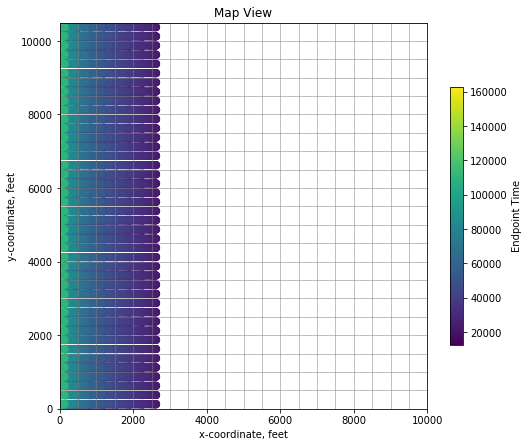

In [7]:
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(7.5, 7.5))
ax.set_aspect('equal')
mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_endpoint(epd, direction='ending', colorbar=True, shrink=0.5)
ax.set_title('Map View')
ax.set_ylabel('y-coordinate, feet')
ax.set_xlabel('x-coordinate, feet')
plt.tight_layout();

Plot the distribution of particle travel times

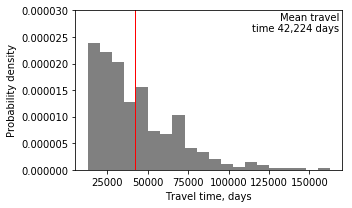

In [8]:
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 3))
ax.hist(epd.time, 20, density=True, color='0.5');
ax.set_ylim(0, 0.00003)
ax.plot([epd.time.mean(), epd.time.mean()], [0,0.00003], lw=1, color='red')
mtxt = 'Mean travel\ntime {:,d} days'.format(int(epd.time.mean()))
ax.text(0.99, 0.99, mtxt, ha='right', va='top', transform=ax.transAxes)
ax.set_ylabel('Probability density')
ax.set_xlabel('Travel time, days')
plt.tight_layout();